In [1]:
from __future__ import print_function, division

import os, sys, itertools

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import astropy.io.ascii as at
import astropy.table as table

In [2]:
def binom_unc(p,n):
    return 1.96 * np.sqrt(p*(1-p)/n)

In [4]:
cs18 = at.read("../../data/cs18/data_cleaned.csv")
print(cs18.dtype)

[('Talk', 'S27'), ('Speaker Gender', 'S1'), ('Questions', 'S9'), ('Session Type', 'S8'), ('Splinter', 'S38'), ('Speaker Type', 'S38'), ('Nsubmitted', '<i8'), ('Notes', 'S44')]


In [5]:
cs19 = at.read("../../data/cs19/data_cleaned.csv")
print(len(cs19))
print(cs19.dtype)
print(len(np.where(cs19["Speaker Gender"]=="F")[0]))

83
[('Epoch', '<i8'), ('Time', 'S17'), ('Talk', 'S33'), ('Chair Gender', 'S1'), ('Speaker Gender', 'S1'), ('Questions', 'S6'), ('Splinter', 'S15'), ('Session Type', 'S8'), ('Speaker Type', 'S11'), ('Comments', 'S103'), ('Comments 2', 'S40'), ('Comments 3', 'S42')]
34


In [6]:
combined = table.vstack([cs18,cs19],join_type="outer")
print(len(combined))
print(combined.dtype)
print(np.unique(combined["Speaker Gender"]))
print(len(np.where(combined["Speaker Gender"]=="F")[0]))

159
[('Talk', 'S33'), ('Speaker Gender', 'S1'), ('Questions', 'S9'), ('Session Type', 'S8'), ('Splinter', 'S38'), ('Speaker Type', 'S38'), ('Nsubmitted', '<i8'), ('Notes', 'S44'), ('Epoch', '<i8'), ('Time', 'S17'), ('Chair Gender', 'S1'), ('Comments', 'S103'), ('Comments 2', 'S40'), ('Comments 3', 'S42')]
Speaker Gender
--------------
             F
             M
            --
63


In [7]:
def split_questions(question_list,max_char=10):
    """
    Split a list of F and M characters into an array.
    """
    
    n_questions = len(question_list)
    
    # Question count is M, W, Total
    question_count = np.zeros((n_questions,3),int)
    
    questions = np.empty((n_questions,max_char),"S1")
    questions[:] = ""

    for i, all_ques in enumerate(question_list):
        #print(all_ques)
        if ("F" in all_ques) or ("M" in all_ques):
            for j, ques in enumerate(all_ques):
                #print(ques)
                questions[i,j] = ques
                if ques=="M":
                    question_count[i,0] += 1
                elif ques=="F":
                    question_count[i,1] += 1
                    
            question_count[i,2] = len(all_ques)
    
    return questions, question_count

In [8]:
cs18_q, cs18_count = split_questions(cs18["Questions"],9)

In [9]:
cs19_q, cs19_count = split_questions(cs19["Questions"])

In [10]:
cs18_flat = cs18_q.flatten()
cs19_flat = cs19_q.flatten()

In [11]:
combined_q, combined_count = split_questions(combined["Questions"])

# Look at raw question numbers

In [12]:
x = np.array(["Men", "Women"])
x_num = np.array([0,1])

y_18 = np.array([len(np.where(cs18_flat=="M")[0]),
        len(np.where(cs18_flat=="F")[0])])
y_19 = np.array([len(np.where(cs19_flat=="M")[0]),
        len(np.where(cs19_flat=="F")[0])])

men_count = np.array([y_18[0],y_19[0]])
women_count = np.array([y_18[1],y_19[1]])

print(y_18,y_19)

totals_conference = np.array([np.sum(y_18),np.sum(y_19)])
print(totals_conference)

[177  46] [197  67]
[223 264]


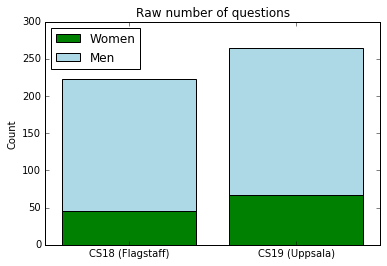

In [13]:
fig = plt.figure()
ax = plt.subplot(111)

ax.bar(x_num, women_count, width=0.8, color="Green",
       align="center", label="Women")
ax.bar(x_num, men_count, width=0.8, color="LightBlue",
       align="center",bottom=women_count,label="Men")

ax.set_title("Raw number of questions")
ax.set_ylabel("Count")
ax.set_xticks(x_num)
ax.set_xticklabels(["CS18 (Flagstaff)","CS19 (Uppsala)"])
ax.set_xlim(-0.5,1.5)

ax.legend(loc=2)

plt.savefig("raw_questions.eps",bbox_inches="tight")

[ 0.05310854  0.05249533]


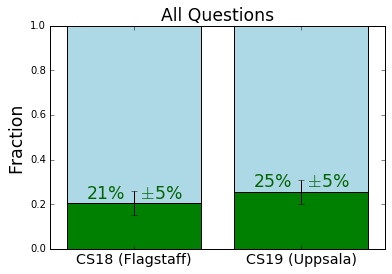

In [14]:
fig = plt.figure()
ax = plt.subplot(111)

ax.bar(x_num, women_count/totals_conference, width=0.8, color="Green",
       align="center",label="Women")
ax.bar(x_num, men_count/totals_conference, width=0.8, color="LightBlue",
       align="center", bottom=women_count/totals_conference,label="Men")

frac = women_count/totals_conference
unc = binom_unc(frac,totals_conference)
print(unc)
ax.text(x_num[0],frac[0]*1.1,"{0:.0f}%   $\pm${1:.0f}%".format(frac[0]*100,unc[0]*100),
        color="DarkGreen",horizontalalignment='center',fontsize="xx-large")
ax.text(x_num[1],frac[1]*1.1,"{0:.0f}%   $\pm${1:.0f}%".format(frac[1]*100,unc[1]*100),
        color="DarkGreen",horizontalalignment='center',fontsize="xx-large")
ax.errorbar(x_num,frac,unc,color="k",ecolor="k",lw=0,elinewidth=1,zorder=100)

ax.set_title("All Questions",fontsize="xx-large")
ax.set_ylabel("Fraction",fontsize="xx-large")
ax.set_xticks(x_num)
ax.set_xticklabels(["CS18 (Flagstaff)","CS19 (Uppsala)"],fontsize="x-large")
ax.set_xlim(-0.5,1.5)

plt.savefig("raw_percentages.eps",bbox_inches="tight")

## What is the effect of a speaker's gender on the number of questions asked them?

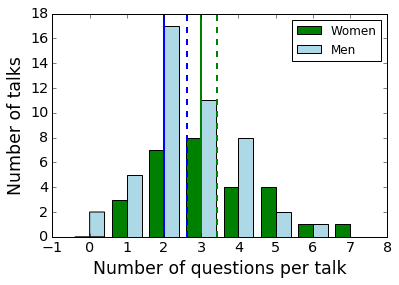

In [15]:
cs18_set = [cs18_count[:,2][cs18["Speaker Gender"]=="F"],
          cs18_count[:,2][cs18["Speaker Gender"]=="M"]]
plt.hist(cs18_set,
         color=["Green","LightBlue"],bins=np.arange(9),histtype="bar",
         align="left",label=["Women","Men"])
ax = plt.gca()
ax.legend(loc=1)
ax.axvline(np.median(cs18_set[0]),color="Green",linestyle="-",lw="2")
ax.axvline(np.median(cs18_set[1]),color="Blue",linestyle="-",lw="2")
ax.axvline(np.mean(cs18_set[0]),color="Green",linestyle="--",lw="2")
ax.axvline(np.mean(cs18_set[1]),color="Blue",linestyle="--",lw="2")
ax.set_xlabel("Number of questions per talk",fontsize="xx-large")
ax.set_ylabel("Number of talks",fontsize="xx-large")
ax.tick_params(labelsize="x-large")

3.0 3.0


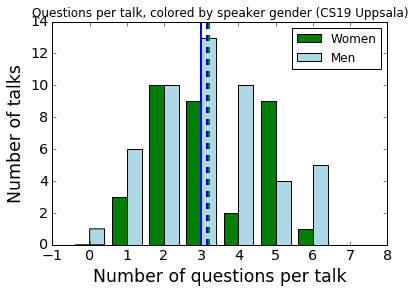

In [16]:
cs19_set = [cs19_count[:,2][cs19["Speaker Gender"]=="F"],
          cs19_count[:,2][cs19["Speaker Gender"]=="M"]]
plt.hist(cs19_set,
         color=["Green","LightBlue"],bins=np.arange(9),histtype="bar",
         align="left",label=["Women","Men"])
ax = plt.gca()
ax.legend(loc=1)
ax.set_title("Questions per talk, colored by speaker gender (CS19 Uppsala)")
ax.axvline(np.median(cs19_set[0]),color="Green",linestyle="-",lw="2")
ax.axvline(np.median(cs19_set[1]),color="Blue",linestyle="-",lw="2")
print(np.median(cs19_set[0]),np.median(cs19_set[1]))
ax.axvline(np.mean(cs19_set[0]),color="Green",linestyle="--",lw="2")
ax.axvline(np.mean(cs19_set[1]),color="Blue",linestyle="--",lw="2")
ax.set_xlabel("Number of questions per talk",fontsize="xx-large")
ax.set_ylabel("Number of talks",fontsize="xx-large")
ax.tick_params(labelsize="x-large")

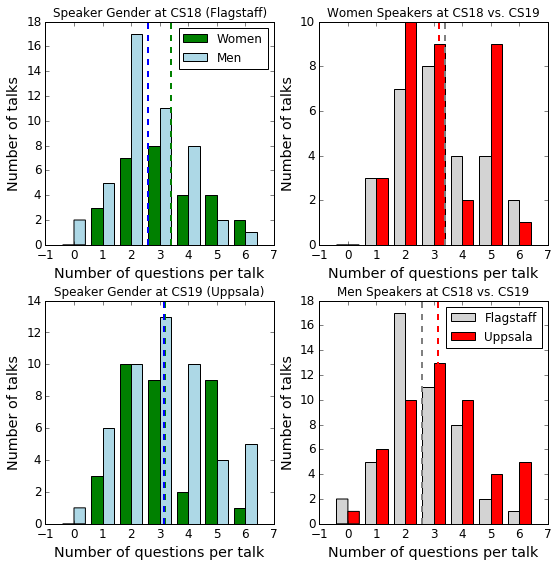

In [17]:
plt.figure(figsize=(9,9))

# Plot CS18 distribution colored by gender
ax1 = plt.subplot(221)
ax1.hist(cs18_set,
         color=["Green","LightBlue"],bins=np.arange(8),histtype="bar",
         align="left",label=["Women","Men"])
ax1.legend(loc=1)

ax1.axvline(np.mean(cs18_set[0]),color="Green",linestyle="--",lw="2")
ax1.axvline(np.mean(cs18_set[1]),color="Blue",linestyle="--",lw="2")
ax1.set_xlabel("Number of questions per talk",fontsize="x-large")
ax1.set_ylabel("Number of talks",fontsize="x-large")
ax1.tick_params(labelsize="large")

ax1.set_title("Speaker Gender at CS18 (Flagstaff)")

# Plot CS19 distribution colored by gender
ax2 = plt.subplot(223, sharex=ax1)

ax2.hist(cs19_set,
         color=["Green","LightBlue"],bins=np.arange(8),histtype="bar",
         align="left",label=["Women","Men"])
ax2.axvline(np.mean(cs19_set[0]),color="Green",linestyle="--",lw="2")
ax2.axvline(np.mean(cs19_set[1]),color="Blue",linestyle="--",lw="2")
ax2.set_xlabel(ax1.get_xlabel(),fontsize="x-large")
ax2.set_ylabel(ax1.get_ylabel(),fontsize="x-large")
ax2.set_title("Speaker Gender at CS19 (Uppsala)")
ax2.tick_params(labelsize="large")

# Plot Women, colored by conference
ax3 = plt.subplot(222, sharex=ax1)
women_set = [cs18_set[0], cs19_set[0]]
ax3.hist(women_set,
         color=["LightGrey","Red"],bins=np.arange(8),histtype="bar",
         align="left",label=["Flagstaff","Uppsala"])
ax3.axvline(np.mean(women_set[0]),color="Grey",linestyle="--",lw="2")
ax3.axvline(np.mean(women_set[1]),color="Red",linestyle="--",lw="2")
ax3.set_xlabel(ax1.get_xlabel(),fontsize="x-large")
ax3.set_ylabel(ax1.get_ylabel(),fontsize="x-large")
ax3.set_title("Women Speakers at CS18 vs. CS19")
ax3.tick_params(labelsize="large")


# Plot men, colored by conference
ax4 = plt.subplot(224, sharex=ax1)
men_set = [cs18_set[1], cs19_set[1]]
ax4.hist(men_set,
         color=["LightGrey","Red"],bins=np.arange(8),histtype="bar",
         align="left",label=["Flagstaff","Uppsala"])
ax4.axvline(np.mean(men_set[0]),color="Grey",linestyle="--",lw="2")
ax4.axvline(np.mean(men_set[1]),color="Red",linestyle="--",lw="2")
ax4.set_xlabel(ax1.get_xlabel(),fontsize="x-large")
ax4.set_ylabel(ax1.get_ylabel(),fontsize="x-large")
ax4.legend(loc=1)
ax4.set_title("Men Speakers at CS18 vs. CS19")
ax4.tick_params(labelsize="large")

plt.subplots_adjust(hspace=0.25)

plt.savefig("speaker_gender.eps",bbox_inches="tight")

# Set up a consistent plot format

In [18]:
def triple_panel(sets, labels, qcount, plot_labels, colors):
    """Calculate statistics and plot a three-panel plot showing 
    1) Raw number of talks included
    2) Mean number of questions/talk
    3) Fraction of questions asked by women
    """
    
    # Calculate statistics
    set_means = np.zeros(4)
    set_stds = np.zeros(4)
    for i,s,l in itertools.izip(np.arange(4),sets,labels):
        set_means[i] = np.mean(qcount[:,2][s])
        set_stds[i] = np.std(qcount[:,2][s])
        print("On average, there were {0:.1f} questions with a {1}".format(set_means[i],l))

    print(" ")

    set_women = np.zeros(4)
    set_totals = np.zeros(4)
    for i,s,l in itertools.izip(np.arange(4),sets,labels):
        set_women[i] = np.sum(qcount[:,1][s])
        set_totals[i] = np.sum(qcount[:,2][s])
        print("{0:.0f} of {1:.0f} questions were asked by women with a {2}".format(set_women[i],
                                                                           set_totals[i],l))
    set_percentages = set_women / set_totals
    set_uncertainties = binom_unc(set_percentages, set_totals)
    print(set_uncertainties)
    
    raw_counts = np.array([len(np.where(s)[0]) for s in sets])
    
    # Plot
    fig = plt.figure(figsize=(8,14))

    x = np.array([1,2,3.5,4.5])
    xticklabels = plot_labels#np.array(["FS, Inv","MS, Inv","FS, Con","MS, Con"]) 

    # Raw # of talks
    ax = plt.subplot(311)
    y = raw_counts

    for i in range(4):
        ax.bar(x[i],y[i],width=1,color=colors[i],align="center")

    ax.set_xticks(x)
    ax.set_xticklabels(plot_labels)
    ax.set_ylabel("Number of talks reported",fontsize="xx-large")
    ax.tick_params(labelsize="x-large")

    # Average number of questions per talk
    y = set_means
    ax = plt.subplot(312)
    for i in range(4):
        ax.bar(x[i],y[i],width=1,color=colors[i],align="center")

    ax.set_xticks(x)
    ax.set_xticklabels(plot_labels)
    ax.set_ylabel("Mean questions per talk",fontsize="xx-large")
    ax.tick_params(labelsize="x-large")

    # Fraction asked by Women
    y = set_percentages
    ax = plt.subplot(313)
    for i in range(4):
        ax.bar(x[i],y[i],width=1,color=colors[i],align="center")

    ax.errorbar(x,set_percentages,set_uncertainties,color="k",
                ecolor="k",fmt="",lw=0,elinewidth=1)

    ax.set_xticks(x)
    ax.set_xticklabels(plot_labels)
    ax.set_ylabel("Fraction of Qs Asked by Women",fontsize="xx-large")
    ax.tick_params(labelsize="x-large")
    ax.set_ylim(ymin=0)

## What is the effect of chair gender on the number of questions allowed?

In [19]:
cs19_chairs = [cs19_count[:,2][cs19["Chair Gender"]=="F"],
          cs19_count[:,2][cs19["Chair Gender"]=="M"]]

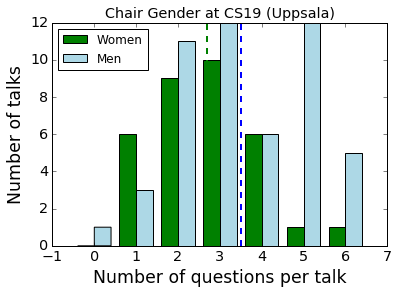

In [20]:
plt.figure()

# Plot CS18 distribution colored by gender
ax1 = plt.subplot(111)
ax1.hist(cs19_chairs,
         color=["Green","LightBlue"],bins=np.arange(8),histtype="bar",
         align="left",label=["Women","Men"])
ax1.legend(loc=2)

ax1.axvline(np.mean(cs19_chairs[0]),color="Green",linestyle="--",lw="2")
ax1.axvline(np.mean(cs19_chairs[1]),color="Blue",linestyle="--",lw="2")
ax1.set_xlabel("Number of questions per talk",fontsize="xx-large")
ax1.set_ylabel("Number of talks",fontsize="xx-large")
ax1.tick_params(labelsize="x-large")

ax1.set_title("Chair Gender at CS19 (Uppsala)",fontsize="x-large")

#plt.savefig("chair_gender_num_questions.eps",bbox_inches="tight")

In [21]:
# Plot combinations of male/female chair+speaker

fspeaker = cs19["Speaker Gender"]=="F"
fchair = cs19["Chair Gender"]=="F"

mspeaker = cs19["Speaker Gender"]=="M"
mchair = cs19["Chair Gender"]=="M"

ffcount = len(np.where(fspeaker & fchair)[0])
fmcount = len(np.where(fchair & mspeaker)[0])

mmcount = len(np.where(mchair & mspeaker)[0])
mfcount = len(np.where(mchair & fspeaker)[0])

On average, there were 2.6 questions with a Female Chair and Female Speaker
On average, there were 2.8 questions with a Female Chair and Male Speaker
On average, there were 3.6 questions with a Male Chair and Female Speaker
On average, there were 3.4 questions with a Male Chair and Male Speaker
 
6 of 23 questions were asked by women with a Female Chair and Female Speaker
18 of 66 questions were asked by women with a Female Chair and Male Speaker
25 of 89 questions were asked by women with a Male Chair and Female Speaker
18 of 86 questions were asked by women with a Male Chair and Male Speaker
[ 0.17945865  0.10744768  0.09337509  0.08598033]


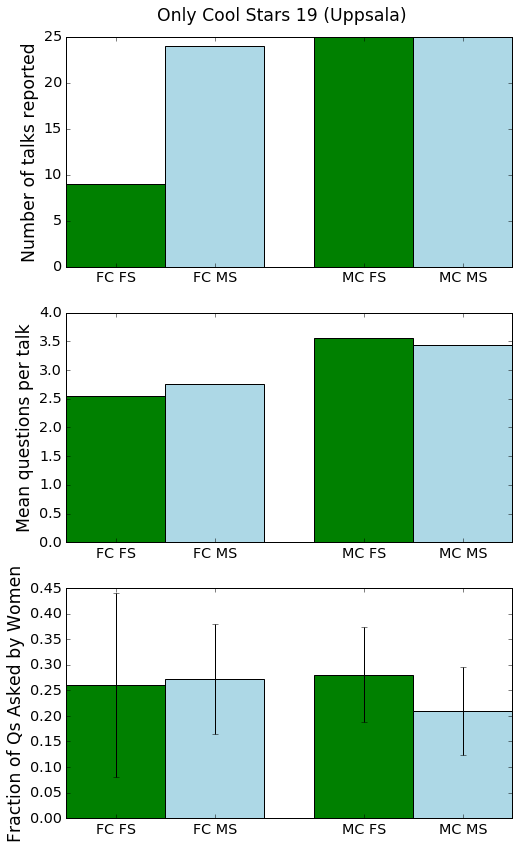

In [22]:
sets = [(fspeaker & fchair), (fchair & mspeaker),
        (mchair & mspeaker), (mchair & fspeaker)]
labels = ["Female Chair and Female Speaker",
          "Female Chair and Male Speaker",
          "Male Chair and Female Speaker",
          "Male Chair and Male Speaker"]
plotlabels = np.array(["FC FS","FC MS","MC FS","MC MS"]) 
colors = np.array(["Green","LightBlue","Green","LightBlue"])
triple_panel(sets,labels,cs19_count,plotlabels,colors)
plt.suptitle("Only Cool Stars 19 (Uppsala)",fontsize="xx-large",y=0.93)

We don't have chair gender data for CS18, and it's not listed in the online or pdf schedule, so I can't pull it from there either

## Is there any difference in how many questions are addressed to invited vs. contributed talks?

### Just CS18

In [23]:
fspeaker = cs18["Speaker Gender"]=="F"
mspeaker = cs18["Speaker Gender"]=="M"

invited = (cs18["Speaker Type"]=="Invited") | (cs18["Speaker Type"]=="Review")
contrib = cs18["Speaker Type"]=="Contributed"

finv = fspeaker & invited
minv = mspeaker & invited

fcon = fspeaker & contrib
mcon = mspeaker & contrib

On average, there were 3.2 questions with a Female Speaker, Invited
On average, there were 2.8 questions with a Male Speaker, Invited
On average, there were 3.5 questions with a Female Speaker, Contributed
On average, there were 2.5 questions with a Male Speaker, Contributed
 
7 of 29 questions were asked by women with a Female Speaker, Invited
13 of 61 questions were asked by women with a Male Speaker, Invited
12 of 70 questions were asked by women with a Female Speaker, Contributed
12 of 55 questions were asked by women with a Male Speaker, Contributed
[ 0.15574691  0.10276698  0.08829043  0.1091533 ]


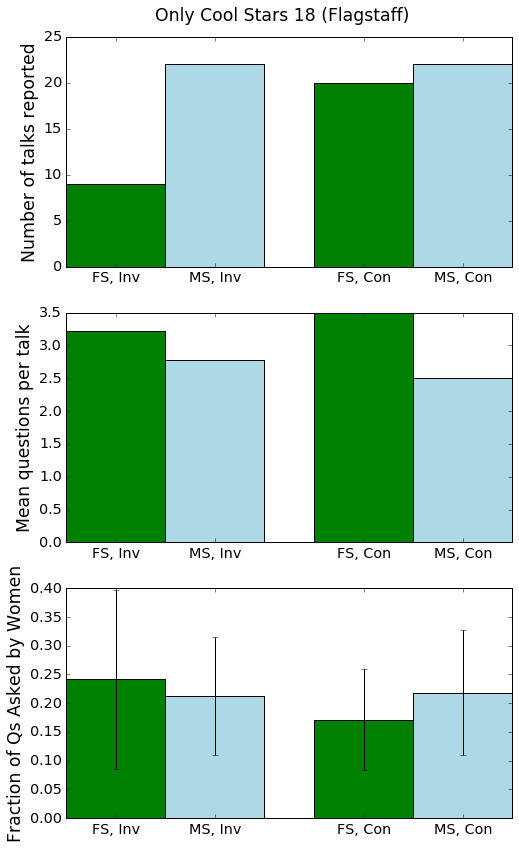

In [24]:
sets = [finv, minv, fcon, mcon]
labels = ["Female Speaker, Invited",
          "Male Speaker, Invited",
          "Female Speaker, Contributed",
          "Male Speaker, Contributed"]
plotlabels = np.array(["FS, Inv","MS, Inv","FS, Con","MS, Con"]) 
colors = np.array(["Green","LightBlue","Green","LightBlue"])
triple_panel(sets,labels,cs18_count,plotlabels,colors)
plt.suptitle("Only Cool Stars 18 (Flagstaff)",fontsize="xx-large",y=0.93)

### Just CS19

In [25]:
fspeaker = cs19["Speaker Gender"]=="F"
mspeaker = cs19["Speaker Gender"]=="M"

invited = (cs19["Speaker Type"]=="invited") | (cs19["Speaker Type"]=="Review")
contrib = cs19["Speaker Type"]=="contributed"

finv = fspeaker & invited
minv = mspeaker & invited

fcon = fspeaker & contrib
mcon = mspeaker & contrib

On average, there were 3.6 questions with a Female Speaker, Invited
On average, there were 3.3 questions with a Male Speaker, Invited
On average, there were 3.0 questions with a Female Speaker, Contributed
On average, there were 3.1 questions with a Male Speaker, Contributed
 
10 of 36 questions were asked by women with a Female Speaker, Invited
8 of 43 questions were asked by women with a Male Speaker, Invited
14 of 73 questions were asked by women with a Female Speaker, Contributed
35 of 112 questions were asked by women with a Male Speaker, Contributed
[ 0.14631505  0.11631411  0.0903154   0.0858437 ]


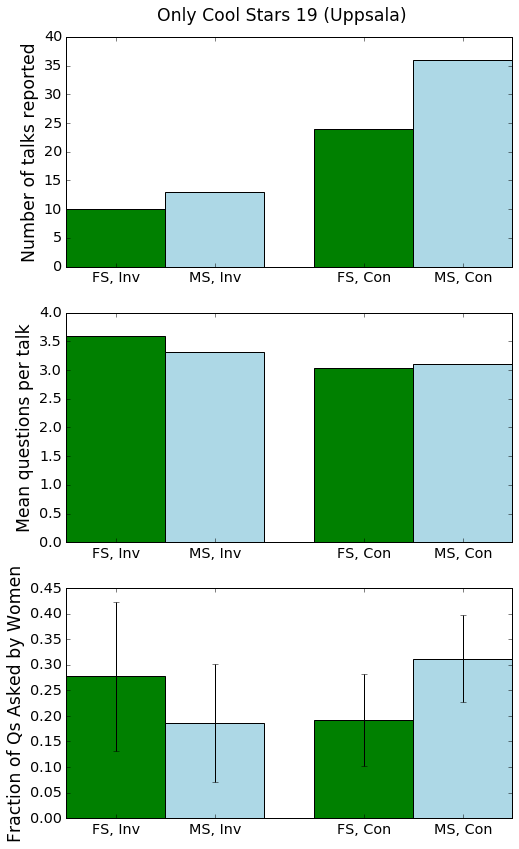

In [26]:
sets = [finv, minv, fcon, mcon]
labels = ["Female Speaker, Invited",
          "Male Speaker, Invited",
          "Female Speaker, Contributed",
          "Male Speaker, Contributed"]
plotlabels = np.array(["FS, Inv","MS, Inv","FS, Con","MS, Con"]) 
colors = np.array(["Green","LightBlue","Green","LightBlue"])
triple_panel(sets,labels,cs19_count,plotlabels,colors)
plt.suptitle("Only Cool Stars 19 (Uppsala)",fontsize="xx-large",y=0.93)

What about just plenaries? 

On average, there were 4.4 questions with a Female Speaker, Invited
On average, there were 5.3 questions with a Male Speaker, Invited
On average, there were 3.2 questions with a Female Speaker, Contributed
On average, there were 3.6 questions with a Male Speaker, Contributed
 
9 of 31 questions were asked by women with a Female Speaker, Invited
5 of 16 questions were asked by women with a Male Speaker, Invited
4 of 42 questions were asked by women with a Female Speaker, Contributed
19 of 62 questions were asked by women with a Male Speaker, Contributed
[ 0.15978872  0.22712108  0.08877771  0.1147571 ]


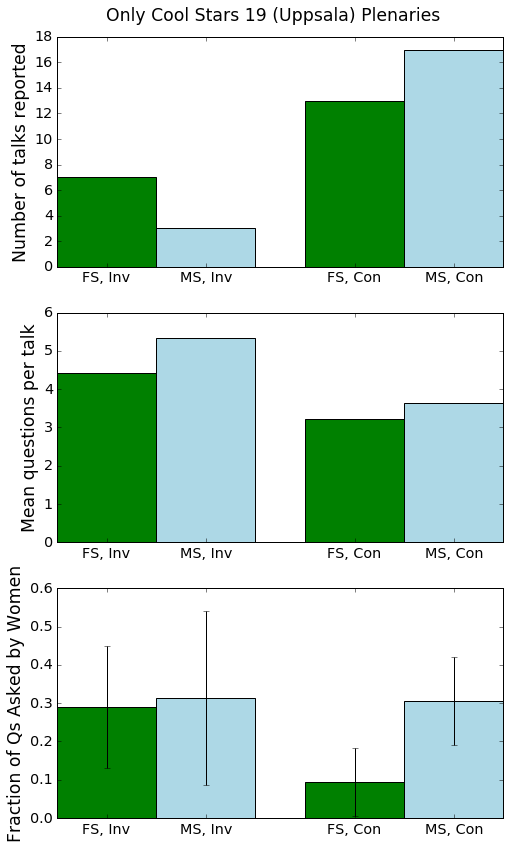

In [27]:
plenary = cs19["Session Type"]=="Plenary"
sets = [finv & plenary, minv & plenary, fcon & plenary, mcon & plenary]
labels = ["Female Speaker, Invited",
          "Male Speaker, Invited",
          "Female Speaker, Contributed",
          "Male Speaker, Contributed"]
plotlabels = np.array(["FS, Inv","MS, Inv","FS, Con","MS, Con"]) 
colors = np.array(["Green","LightBlue","Green","LightBlue"])
triple_panel(sets,labels,cs19_count,plotlabels,colors)
plt.suptitle("Only Cool Stars 19 (Uppsala) Plenaries",fontsize="xx-large",y=0.93)

### Combined Sample

In [28]:
fspeaker = combined["Speaker Gender"]=="F"
mspeaker = combined["Speaker Gender"]=="M"

invited = ((combined["Speaker Type"]=="invited") | (combined["Speaker Type"]=="Review") 
           | (combined["Speaker Type"]=="Invited"))
contrib = (combined["Speaker Type"]=="contributed") | (combined["Speaker Type"]=="Contributed")

finv = fspeaker & invited
minv = mspeaker & invited

fcon = fspeaker & contrib
mcon = mspeaker & contrib

On average, there were 3.4 questions with a Female Speaker, Invited
On average, there were 3.0 questions with a Male Speaker, Invited
On average, there were 3.2 questions with a Female Speaker, Contributed
On average, there were 2.9 questions with a Male Speaker, Contributed
 
17 of 65 questions were asked by women with a Female Speaker, Invited
21 of 104 questions were asked by women with a Male Speaker, Invited
26 of 143 questions were asked by women with a Female Speaker, Contributed
47 of 167 questions were asked by women with a Male Speaker, Contributed
[ 0.10683932  0.07715334  0.06321667  0.06820574]


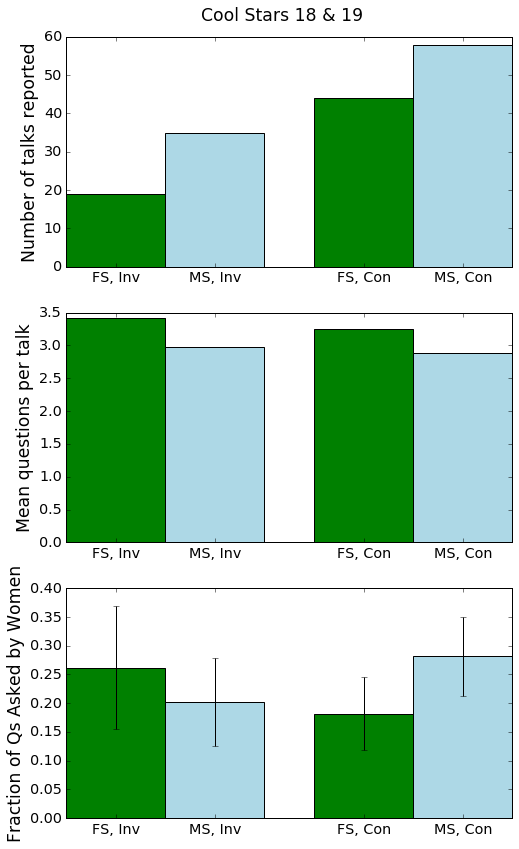

In [29]:
sets = [finv, minv, fcon, mcon]
labels = ["Female Speaker, Invited",
          "Male Speaker, Invited",
          "Female Speaker, Contributed",
          "Male Speaker, Contributed"]
plotlabels = np.array(["FS, Inv","MS, Inv","FS, Con","MS, Con"]) 
colors = np.array(["Green","LightBlue","Green","LightBlue"])
triple_panel(sets,labels,combined_count,plotlabels,colors)
plt.suptitle("Cool Stars 18 & 19",fontsize="xx-large",y=0.93)

# Just compare plenary sessions

In [46]:
def compare_women_fractions(women_count, men_count, totals_conference,
                           colors=["Green","LightBlue"],
                           xlabels=["CS18 (Flagstaff)","CS19 (Uppsala)"]):
    fig = plt.figure()
    ax = plt.subplot(111)

    x_num = np.array([0,1])
    ax.bar(x_num, women_count/totals_conference, width=0.8, color=colors[0],
           align="center",label="Women")
    ax.bar(x_num, men_count/totals_conference, width=0.8, color=colors[1],
           align="center", bottom=women_count/totals_conference,label="Men")

    frac = women_count/totals_conference
    unc = binom_unc(frac,totals_conference)
    print(unc)
    ax.text(x_num[0],frac[0]*1.1,"{0:.0f}%   $\pm${1:.0f}%".format(frac[0]*100,unc[0]*100),
            color="DarkGreen",horizontalalignment='center',fontsize="xx-large")
    ax.text(x_num[1],frac[1]*1.1,"{0:.0f}%   $\pm${1:.0f}%".format(frac[1]*100,unc[1]*100),
            color="DarkGreen",horizontalalignment='center',fontsize="xx-large")
    ax.errorbar(x_num,frac,unc,color="k",ecolor="k",lw=0,elinewidth=1,zorder=100)

    ax.set_ylabel("Fraction of Qs from women",fontsize="xx-large")
    ax.set_xticks(x_num)
    ax.set_xticklabels(xlabels,fontsize="x-large")
    ax.set_xlim(-0.5,1.5)
    ax.tick_params(labelsize="x-large")
    legend = ax.legend(loc=2)
    frame = legend.get_frame()
    frame.set_facecolor('w')


In [31]:
cs18_plenary = cs18[cs18["Session Type"]=="Plenary"]
cs19_plenary = cs19[cs19["Session Type"]=="Plenary"]

cs18_pq, cs18_pcount = split_questions(cs18_plenary["Questions"],9)
cs19_pq, cs19_pcount = split_questions(cs19_plenary["Questions"],10)

cs18_pflat = cs18_pq.flatten()
cs19_pflat = cs19_pq.flatten()

In [32]:
y_18 = np.array([len(np.where(cs18_pflat=="M")[0]),
        len(np.where(cs18_pflat=="F")[0])])
y_19 = np.array([len(np.where(cs19_pflat=="M")[0]),
        len(np.where(cs19_pflat=="F")[0])])
totals_conference = np.array([np.sum(y_18),np.sum(y_19)])

men_count = np.array([y_18[0],y_19[0]])
women_count = np.array([y_18[1],y_19[1]])

print("CS 18 (Flagstaff) had {0} men and {1} women ask questions in plenaries "
      "({2} total questions)".format(y_18[0],y_18[1],totals_conference[0]))
print("CS 19 (Uppsala) had {0} men and {1} women ask questions in plenaries "
      "({2} total questions)".format(y_19[0],y_19[1],totals_conference[1]))

CS 18 (Flagstaff) had 65 men and 22 women ask questions in plenaries (87 total questions)
CS 19 (Uppsala) had 114 men and 37 women ask questions in plenaries (151 total questions)


[ 0.09133668  0.06860313]


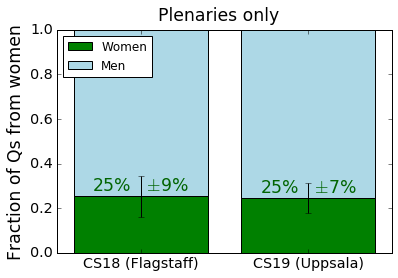

In [47]:
compare_women_fractions(women_count, men_count, totals_conference)
plt.suptitle("Plenaries only",fontsize="xx-large")
plt.savefig("plenaries_fraction.eps",bbox_inches="tight")